Total Rows Loaded: 37674
  TripId  Time_Step   Latitude  Longitude  Speed(m/s)  Acceleration(m/s^2)  \
0    T-1          1  39.981798 -83.033740    0.507812                  NaN   
1    T-1          2  39.981688 -83.033573    0.500000             0.333333   
2    T-1          3  39.981581 -83.033420    0.500000             0.416667   
3    T-1          4  39.981470 -83.033276    0.507812             0.500000   
4    T-1          5  39.981345 -83.033133    0.515625             0.500000   

   Jerk(m/s^3)  Braking_Intensity  Heading_Change(degrees)  SASV  \
0          NaN                0.0                      NaN     1   
1          NaN                0.2                 0.726016     1   
2     0.625862                0.0                 0.735479     1   
3     0.625862                0.0                 0.750949     1   
4     0.501149                0.0                 0.770902     1   

   Speed_Violation  Driving_Score Driving_Category  DriverId  
0                1            NaN 

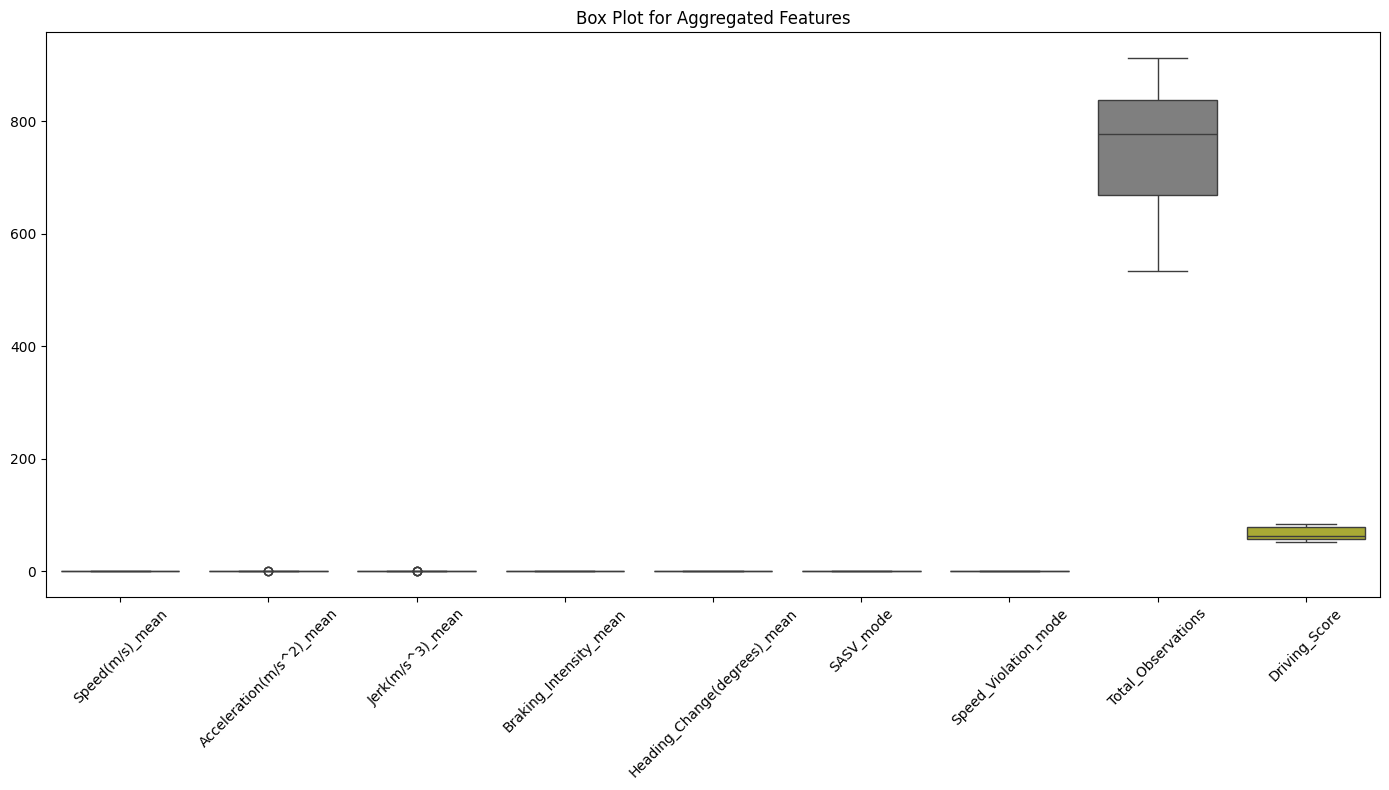

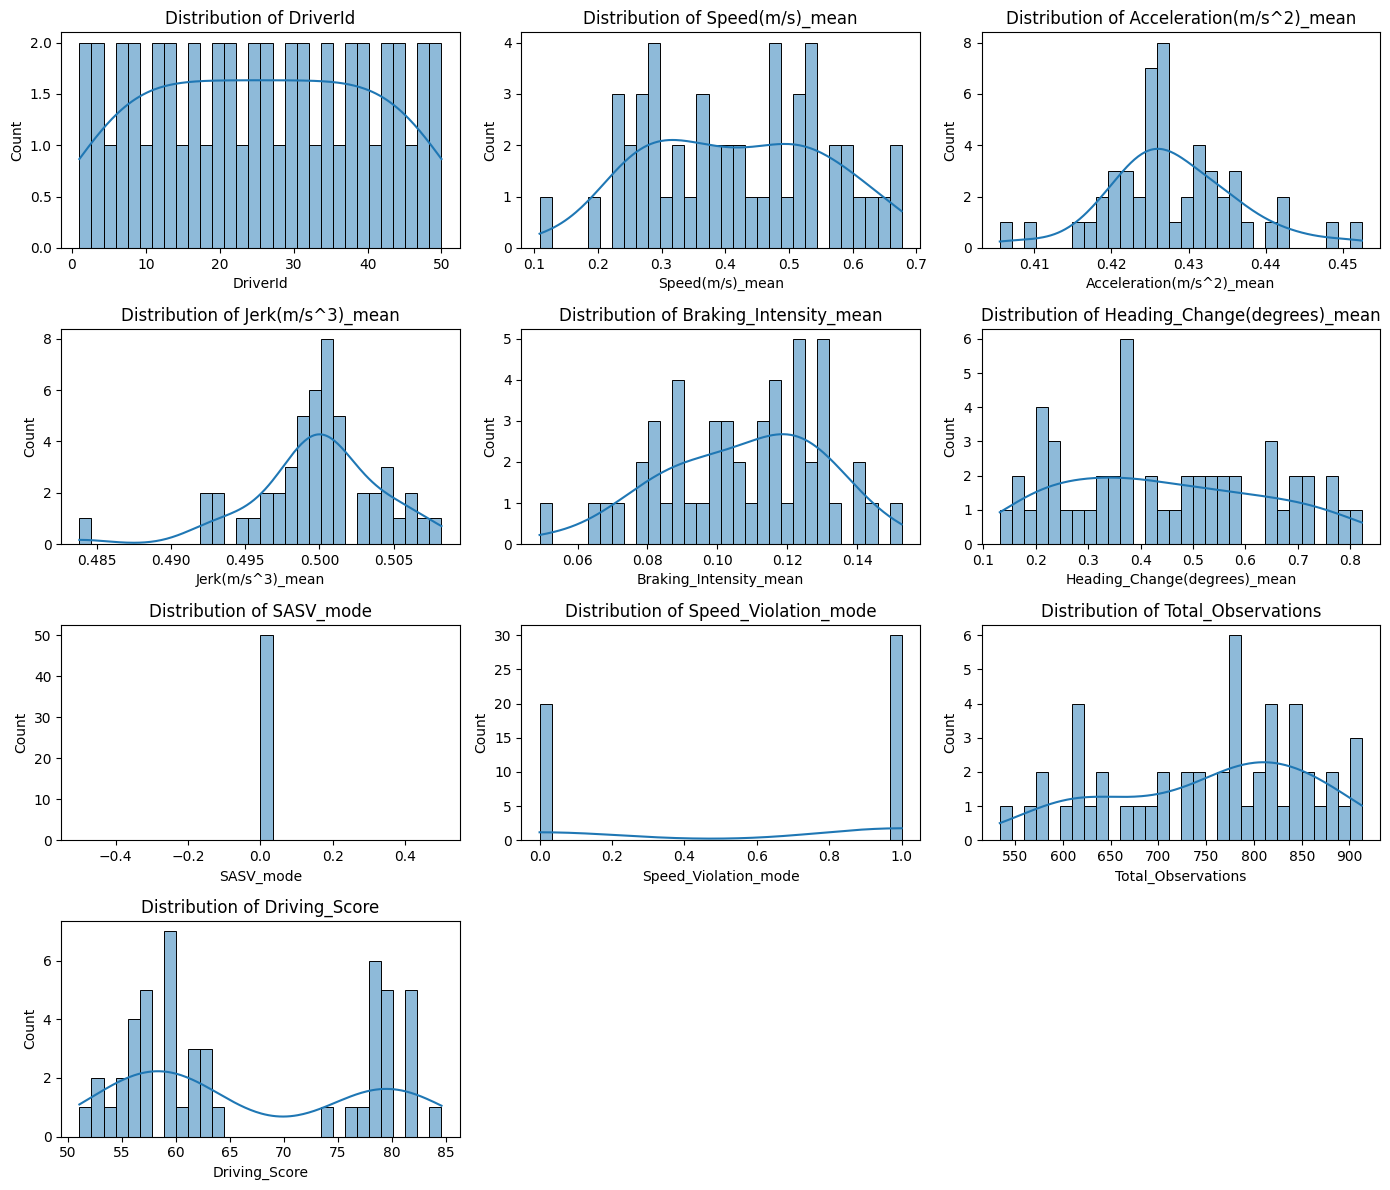

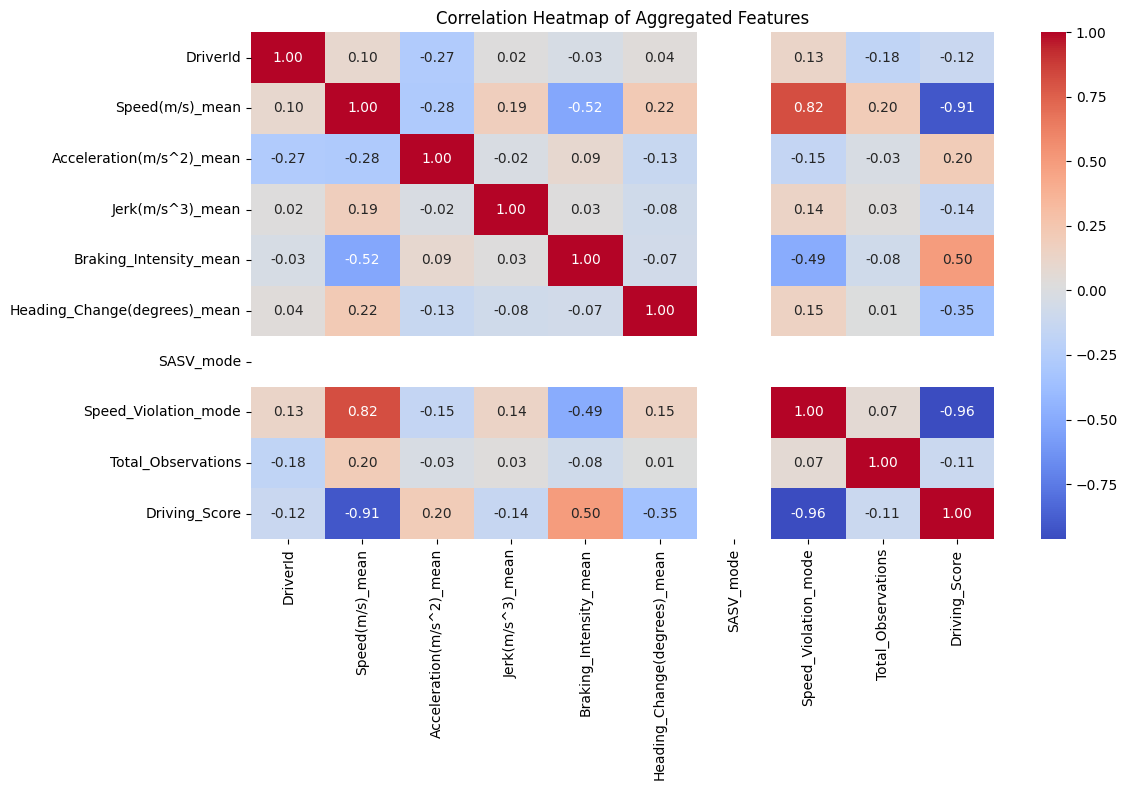

Plots saved successfully.


In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Ensure the 'data' directory exists
output_directory = '../data'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Load the processed trip-level data
processed_data_path = '../data/processed_data.csv'
df = pd.read_csv(processed_data_path)

# Assign DriverId based on TripId (assuming that TripId is of the format 'T-x')
df['DriverId'] = df['TripId'].apply(lambda x: int(x.split('-')[1]))

# Check if data is correctly loaded
print(f"Total Rows Loaded: {len(df)}")
print(df.head())

# Aggregate data by DriverId and calculate mean values for key features
driver_aggregated_data = df.groupby('DriverId').agg({
    'Speed(m/s)': 'mean',
    'Acceleration(m/s^2)': 'mean',
    'Jerk(m/s^3)': 'mean',
    'Braking_Intensity': 'mean',
    'Heading_Change(degrees)': 'mean',
    'SASV': lambda x: stats.mode(x, keepdims=True)[0][0],  # Mode for binary SASV
    'Speed_Violation': lambda x: stats.mode(x, keepdims=True)[0][0],  # Mode for binary Speed Violation
    'Time_Step': 'count'  # Total observations for the driver
}).reset_index()

# Flatten multi-index columns
driver_aggregated_data.columns = [
    'DriverId', 'Speed(m/s)_mean', 'Acceleration(m/s^2)_mean', 'Jerk(m/s^3)_mean', 
    'Braking_Intensity_mean', 'Heading_Change(degrees)_mean', 'SASV_mode', 
    'Speed_Violation_mode', 'Total_Observations'
]

# ---------- Driving Score Calculation for Aggregated Data ---------- #
driver_aggregated_data['Driving_Score'] = 100

# Apply penalties based on mean values
driver_aggregated_data['Driving_Score'] -= driver_aggregated_data['Speed(m/s)_mean'] * 25  # Speed penalty
driver_aggregated_data['Driving_Score'] -= driver_aggregated_data['Acceleration(m/s^2)_mean'] * 15  # Acceleration penalty
driver_aggregated_data['Driving_Score'] -= driver_aggregated_data['Jerk(m/s^3)_mean'] * 5  # Jerk penalty
driver_aggregated_data['Driving_Score'] -= driver_aggregated_data['Braking_Intensity_mean'] * 5  # Braking intensity penalty
driver_aggregated_data['Driving_Score'] -= driver_aggregated_data['Heading_Change(degrees)_mean'] * 10  # Heading change penalty

# Penalty for violations
driver_aggregated_data['Driving_Score'] -= driver_aggregated_data['SASV_mode'] * 15  # Penalty for violating sensitive areas
driver_aggregated_data['Driving_Score'] -= driver_aggregated_data['Speed_Violation_mode'] * 15  # Penalty for general speed violation

# Ensure the score is within the range [0, 100]
driver_aggregated_data['Driving_Score'] = driver_aggregated_data['Driving_Score'].clip(upper=100, lower=0)

# Driving Category based on score
def categorize_driving_score(score):
    if score > 80:
        return 'Safe'
    elif score > 60:
        return 'Moderate'
    else:
        return 'Risky'

driver_aggregated_data['Driving_Category'] = driver_aggregated_data['Driving_Score'].apply(categorize_driving_score)

# Save aggregated data for future bulk processing
aggregated_output_path = '../data/driver_aggregated_data.csv'
driver_aggregated_data.to_csv(aggregated_output_path, index=False)

print(f"Aggregated data by driver saved to {aggregated_output_path}")

# ---------- Visualizations ---------- #

# ---------- Box Plot for Aggregated Data Features ---------- #
plt.figure(figsize=(14, 8))
sns.boxplot(data=driver_aggregated_data.drop('DriverId', axis=1))
plt.title('Box Plot for Aggregated Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_directory, 'aggregated_feature_boxplot.png'))
plt.show()

# ---------- Histograms for Aggregated Features ---------- #
numeric_columns = driver_aggregated_data.select_dtypes(include=[np.number]).columns

n_cols = 3  # Number of columns for the subplot grid
n_rows = np.ceil(len(numeric_columns) / n_cols).astype(int)  # Calculate the required number of rows

plt.figure(figsize=(14, n_rows * 3))
for idx, col in enumerate(numeric_columns, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.histplot(driver_aggregated_data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig(os.path.join(output_directory, 'aggregated_feature_histograms.png'))
plt.show()

# ---------- Correlation Heatmap ---------- #
plt.figure(figsize=(12, 8))
correlation_matrix = driver_aggregated_data.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Aggregated Features')
plt.tight_layout()
plt.savefig(os.path.join(output_directory, 'correlation_heatmap.png'))
plt.show()

print("Plots saved successfully.")
